# Using GPUs & TPUs with TF-Agents

### Profile in-notebook training

> Note: this notebook will only be useful if you have an accelerator (GPU or TPU) attached to the instance.

#### Goals

* Use the [TensorBoard Profiler](https://www.tensorflow.org/guide/profiler) to profile the RL training job, and compare this to other ML training jobs
* Visualize information such as operation statistics on different devices, tracing, etc. 
* Discuss these performance characteristics with respect to decisions in the code base (e.g., the structure of the Agent class), the use of TF helpers like `@tf.function`, and the order of operations in the input data pipeline

**Why?**
* Accelerators like GPUs and TPUs are certainly advantageous, but they are also the most expensive component(s) of a training job
* Before scaling to a full training job, it's best to make sure we are fully utilizing the chosen device(s), and doing this in-notebook can quickly help uncover any red flags 

We'll mainly look to address any bottlenecks in the input pipeline

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

### imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform
from google.cloud import storage

# tensorflow
import tensorflow as tf

from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.metrics import tf_metrics

from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.trajectories import trajectory
from tf_agents.policies import policy_saver
from tf_agents.specs import array_spec

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils as tfa_train_utils
from tf_agents.utils import common

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.utils import train_utils, reward_factory
from src.data import data_utils, data_config
from src.trainer import train_perarm as train_perarm
from src.networks import encoding_network as emb_features
from src.agents import agent_factory as agent_factory

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [5]:
import wrapt
from tensorflow.python.platform import build_info

print(f"cudnn version  : {build_info.build_info['cudnn_version']}")
print(f"cuda version   : {build_info.build_info['cuda_version']}")

print(f"wrapt          : {wrapt.__version__}")
print(f"tensorflow     : {tf.__version__}")
print(f"aiplatform SDK : {aiplatform.__version__}")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cudnn version  : 8
cuda version   : 11.8
wrapt          : 1.16.0
tensorflow     : 2.13.0
aiplatform SDK : 1.71.0
Num GPUs Available:  1


In [7]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [8]:
print(f"device: {device.name.decode()}")

# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

device: Tesla T4


## Specify dataset

In [9]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

# !gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m


### Generate Vocabs

In [10]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



### train config

In [11]:
NUM_OOV_BUCKETS       = 1
GLOBAL_EMBEDDING_SIZE = 12
MV_EMBEDDING_SIZE     = 16 #32

NUM_GLOBAL_FEATURES   = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES      = len(data_utils.MOVIE_FEATURE_NAMES)    # 5

EXPECTED_GLOBAL_DIM   = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
EXPECTED_PER_ARM_DIM  = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES

EXPECTED_GLOBAL_LAYERS   = [
    EXPECTED_GLOBAL_DIM,
    int(EXPECTED_GLOBAL_DIM/2),
    int(EXPECTED_GLOBAL_DIM/4)
]
EXPECTED_ARM_LAYERS      = [
    EXPECTED_PER_ARM_DIM,
    int(EXPECTED_PER_ARM_DIM/2),
    int(EXPECTED_PER_ARM_DIM/4)
]
EXPECTED_FIRST_COMMON_LAYER = EXPECTED_GLOBAL_LAYERS[-1] + EXPECTED_ARM_LAYERS[-1]
EXPECTED_COMMON_LAYERS = [
    int(EXPECTED_FIRST_COMMON_LAYER),
    # int(EXPECTED_FIRST_COMMON_LAYER/2),
    int(EXPECTED_FIRST_COMMON_LAYER/4)
]

print(f"NUM_OOV_BUCKETS        : {NUM_OOV_BUCKETS}")
print(f"GLOBAL_EMBEDDING_SIZE  : {GLOBAL_EMBEDDING_SIZE}")
print(f"MV_EMBEDDING_SIZE      : {MV_EMBEDDING_SIZE}")
print(f"EXPECTED_GLOBAL_DIM    : {EXPECTED_GLOBAL_DIM}")
print(f"EXPECTED_PER_ARM_DIM   : {EXPECTED_PER_ARM_DIM}")
print(f"EXPECTED_GLOBAL_LAYERS : {EXPECTED_GLOBAL_LAYERS}")
print(f"EXPECTED_ARM_LAYERS    : {EXPECTED_ARM_LAYERS}")
print(f"EXPECTED_COMMON_LAYERS : {EXPECTED_COMMON_LAYERS}")

NUM_OOV_BUCKETS        : 1
GLOBAL_EMBEDDING_SIZE  : 12
MV_EMBEDDING_SIZE      : 16
EXPECTED_GLOBAL_DIM    : 72
EXPECTED_PER_ARM_DIM   : 64
EXPECTED_GLOBAL_LAYERS : [72, 36, 18]
EXPECTED_ARM_LAYERS    : [64, 32, 16]
EXPECTED_COMMON_LAYERS : [34, 8]


In [12]:
BATCH_SIZE             = 128
EVAL_BATCH_SIZE        = 1
NUM_ACTIONS            = 2 
#this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)

print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2


#### confirm GLOBAL and PER_ARM DIMs

**we only need a subset of data for profiling!**

In [13]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files[:3]
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

data

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
 array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'pr

In [14]:
del iterator
del train_dataset

In [15]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

test_globals = embs._get_global_context_features(data)
test_arms = embs._get_per_arm_features(data)

GLOBAL_DIM = test_globals.shape[1]
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

PER_ARM_DIM = test_arms.shape[1]
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

GLOBAL_DIM: 72
PER_ARM_DIM: 64


### TensorSpecs

In [16]:
from tf_agents.specs import array_spec

observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}

action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1,
    name="action_spec"
)

time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)

reward_spec = {
    "reward": array_spec.ArraySpec(shape=[BATCH_SIZE], dtype=np.float32, name="reward")
}
reward_tensor_spec = train_utils.from_spec(reward_spec)

## Distribution strategy

Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:

* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [17]:
use_gpu = True
use_tpu = False

distribution_strategy = strategy_utils.get_strategy(tpu=use_tpu, use_gpu=use_gpu)

NUM_REPLICAS = distribution_strategy.num_replicas_in_sync
NUM_REPLICAS

1

### Config

In [18]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'NeuralLinUCB' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ==================================
# Agent's Preprocess Network layers
# ==================================
NETWORK_TYPE       = "commontower" # 'dotproduct' | 'dotproduct'

GLOBAL_LAYERS      = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS         = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])

COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER), 
    # int(FIRST_COMMON_LAYER/2),
    int(FIRST_COMMON_LAYER/4)
]

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

HPARAMS = {
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [34, 8],
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [72, 36, 18],
 'learning_rate': 0.05,
 'model_type': 'NeuralLinUCB',
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_layers': [64, 32, 16]}


### trajectory function

In [19]:
# with distribution_strategy.scope():
    
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

## Create Agent

> Note: writting distributions and historgrams of gradients and variables will negatively impact training performance

* set `summarize_grads_and_vars = False` for best training performance
* keep `debug_summaries = True` to track training metrics (e.g., loss / regret)

In [20]:
# with distribution_strategy.scope():
    
global_step = tf.compat.v1.train.get_or_create_global_step()

agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    summarize_grads_and_vars = False,
    debug_summaries = True
)

agent.initialize()

print(f"Agent: {agent.name}")

if NETWORK_TYPE:
    print(f"NETWORK_TYPE: {NETWORK_TYPE}")

Agent: neural_linucb_agent
NETWORK_TYPE: commontower


### GPU stuff

* `TF_GPU_THREAD_MODE=gpu_private` ensures that GPU kernels are launched from their own dedicated threads, and don't get queued behind tf.data work.

In [23]:
import os

TF_GPU_THREAD_COUNT   = '1'      # '1' | '4' | '8'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_THREAD_MODE']='gpu_private'
os.environ['TF_GPU_THREAD_COUNT']=f"{TF_GPU_THREAD_COUNT}"
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

## Vertex Experiment

In [25]:
EXP_VERSION="v9"

In [26]:
EXPERIMENT_NAME   = f'02c-bandit-gpu-{EXP_VERSION}' # customize as needed

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    # experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02c-bandit-gpu-v9
RUN_NAME          : run-20241209-215822

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v9/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v9/run-20241209-215822
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v9/run-20241209-215822/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v9/run-20241209-215822/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v9/run-20241209-215822/artifacts


### TB Summary writer

In [27]:
# ====================================================
# TB summary writer
# ====================================================
# with distribution_strategy.scope():

train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}", flush_millis=10 * 1000
)

train_summary_writer.set_as_default()

## Train loops

In [28]:
NUM_EPOCHS           = 3
NUM_ITER_STEPS       = 100
STEPS_PER_LOOP       = 1
LOG_INTERVAL         = 10
CHKPT_INTERVAL       = 1000

print(f"NUM_EPOCHS           : {NUM_EPOCHS}")
print(f"NUM_ITER_STEPS       : {NUM_ITER_STEPS}")
print(f"STEPS_PER_LOOP       : {STEPS_PER_LOOP}")
print(f"LOG_INTERVAL         : {LOG_INTERVAL}")
print(f"CHKPT_INTERVAL       : {CHKPT_INTERVAL}")

NUM_EPOCHS           : 3
NUM_ITER_STEPS       : 100
STEPS_PER_LOOP       : 1
LOG_INTERVAL         : 10
CHKPT_INTERVAL       : 1000


In [29]:
#start the timer and training
start_time = time.time()

metric_results, agent = train_perarm.train_perarm(
    agent = agent,
    embs = embs,
    hparams = HPARAMS,
    train_files = train_files,
    reward_spec = reward_tensor_spec,
    global_dim = GLOBAL_DIM,
    per_arm_dim = PER_ARM_DIM,
    num_epochs = NUM_EPOCHS,
    num_iterations = NUM_ITER_STEPS,
    steps_per_loop = STEPS_PER_LOOP,
    chkpt_interval = CHKPT_INTERVAL,
    log_interval = LOG_INTERVAL,
    log_dir = LOG_DIR,
    model_dir = ARTIFACTS_DIR,
    chkpoint_dir = CHECKPT_DIR,
    use_gpu = True,
    use_tpu = False,
    profiler = False,
    global_step = global_step,
    train_summary_writer = train_summary_writer,
    strategy = distribution_strategy,
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

distribution_strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fdec42d33a0>
Inpsecting agent policy from train_peram file...
agent.policy: <tf_agents.bandits.policies.neural_linucb_policy.NeuralLinUCBPolicy object at 0x7fdeb0285930>
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v9/chkpoint
agent.train_step_counter: 0
starting train loop...

starting epoch: 1
step = 0: loss = 14.520000457763672
step = 10: loss = 3.319999933242798
step = 20: loss = 1.4600000381469727
step = 30: loss = 1.1299999952316284
step = 40: loss = 1.0199999809265137
step = 50: loss = 1.2999999523162842
step = 60: loss = 1.6699999570846558
step = 70: loss = 1.5299999713897705
step = 80: loss = 0.9900000095367432
step = 90: loss = 1.440000057220459
epoch_mins: 0

34.963 steps/sec

starting epoch: 2
step = 100: loss = 1.440000057220459
step = 110: loss = 1.0700000524520874
step = 120: loss = 1.149999976158142
step = 130: loss = 1.070000052452

## Evaluate Train job

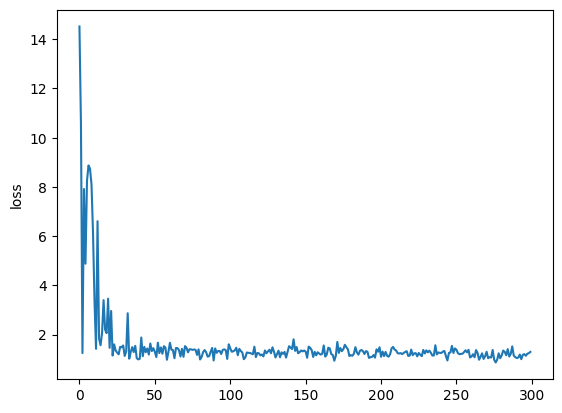

In [30]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

### GPU profiling

#### Load TensorBoard

> on the right-hand side, find `PROFILE` in the drop down:

<img src="imgs/getting_profiler.png" 
     align="center" 
     width="850"
     height="850"/>
     
<!-- tf_vertex_agents/imgs/getting_profiler.png -->

In [37]:
from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

In [38]:
# %load_ext tensorboard
%reload_ext tensorboard

In [40]:
# %tensorboard --logdir=$LOG_DIR

**Finished**